# Comparative Analysis of Thyroid Disease Classification Models

**Author:** Ashutosh Shirsat  
**Project:** Data Science/ML   
**Objective:** Compare and evaluate three different models, namely Generalized Linear Model (GLM), Support Vector Machines (SVM), Random Forest (RF) and K-Nearest Neighbour (KNN) to determine the most suitable model for accurate predictions on this dataset.

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

1. Load and Prepare Data
Purpose: Read the data, identify numeric and categorical features, set up target variable.

In [14]:
# 1a. Load your data
target_col = 'thyroid'
data = pd.read_csv("data/thyroidData_Lasso_featureselected.csv")

X = data.drop(columns=target_col)
y = data[target_col].astype(int)

# 2a. Identify feature types
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()

In [15]:
# 1b. Load data for Random Forest Classifier - without lasso feature selection.
data_RF = pd.read_csv("data/cleanThyroidData.csv")

X_RF = data_RF.drop(columns=target_col)
y_RF = data_RF[target_col].astype(int)

# 2b. Identify feature types
categorical_features_RF = X_RF.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features_RF = X_RF.select_dtypes(include=[np.number, 'bool']).columns.tolist()

2. Train/Test Split
Purpose: Split data so model evaluation is honest.

In [16]:
# 3a. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123456
)
# 3b. Train/test split for Random Forest Classifier
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(
    X_RF, y_RF, test_size=0.2, stratify=y_RF, random_state=123456
)

3. Preprocessing Pipeline
Purpose: One-hot encode categoricals, scale numerics.

In [17]:
# 4. Preprocessing Pipeline
numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 4a. Preprocessing Pipeline for Logistic Regression, SVM, KNN
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)

    
])# 4b. Preprocessing Pipeline for Random Forest Classifier
preprocessor_RF = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features_RF),
    ('cat', categorical_transformer, categorical_features_RF)
])



4. Model Pipelines and Hyperparameter Grids
Purpose: Define models and tuning options, all within pipelines.

In [18]:
# 5. Define model pipelines, hyperparameter grids, and results dictionary for all classifiers
models = {
    "GLM": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(solver='lbfgs', max_iter=2000, random_state=123456))
        ]),
        "param_grid": {
            "classifier__C": np.logspace(-3, 2, 10)
        },
        "results": {}
    },
    "SVM": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", SVC(probability=True, kernel="rbf", random_state=123456))
        ]),
        "param_grid": {
            "classifier__C": [0.25, 1, 1.5, 2, 5],
            "classifier__gamma": [0, 0.5, 1.5]
        },
        "results": {}
    },
    "RandomForest": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor_RF),
            ("classifier", RandomForestClassifier(n_estimators=600, random_state=123456))
        ]),
        "param_grid": {
            "classifier__max_features": ["sqrt", "log2", None]
        },
        "results": {}
    },
    "KNN": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", KNeighborsClassifier())
        ]),
        "param_grid": {
            "classifier__n_neighbors": [3, 5, 7, 9, 11],
            "classifier__weights": ["uniform", "distance"]
        },
        "results": {}
    }
}

# The following defines a 5-fold stratified cross-validation splitter for use in model selection and hyperparameter tuning.
# StratifiedKFold ensures each fold preserves the percentage of samples for each class, which is important for imbalanced datasets.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123456)

5. Model Selection and Hyperparameter Tuning
Purpose: Use cross-validation for model selection and tuning.

In [19]:
# This function trains and evaluates a model using GridSearchCV with cross-validation.
def train_and_evaluate(model_name, model_dict, X_train, X_test, y_train, y_test, numeric_features, categorical_features):
    # This function performs model training and evaluation for a given model.
    # It uses GridSearchCV for hyperparameter tuning with cross-validation,
    # fits the model on the training data, evaluates on the test data,
    # and stores results (best params, metrics, feature importance) in the model_dict.
    #
    # Parameters:
    #   model_name (str): Name of the model (e.g., "GLM", "SVM", "RandomForest", "KNN").
    #   model_dict (dict): Dictionary containing the estimator pipeline, param_grid, and results.
    #   X_train (pd.DataFrame): Training features.
    #   X_test (pd.DataFrame): Test features.
    #   y_train (pd.Series): Training target.
    #   y_test (pd.Series): Test target.
    #   numeric_features (list): List of numeric feature names.
    #   categorical_features (list): List of categorical feature names.
    #
    # Returns:
    #   dict: Updated model_dict with fitted grid, best params, metrics, and feature importance.
    
    print(f"\n==== {model_name} ====")
    grid = GridSearchCV(model_dict["estimator"], model_dict["param_grid"], cv=cv, scoring="roc_auc", n_jobs=-1, return_train_score=True)
    grid.fit(X_train, y_train)
    model_dict["grid"] = grid
    model_dict["results"]["best_params"] = grid.best_params_
    model_dict["results"]["best_cv_auc"] = grid.best_score_
    print("Best params:", grid.best_params_)
    print("Best CV ROC-AUC:", grid.best_score_)

    # Test set evaluation
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:,1]
    model_dict["results"]["test_auc"] = roc_auc_score(y_test, y_proba)
    model_dict["results"]["test_accuracy"] = accuracy_score(y_test, y_pred)
    model_dict["results"]["test_precision"] = precision_score(y_test, y_pred)
    model_dict["results"]["test_recall"] = recall_score(y_test, y_pred)
    model_dict["results"]["test_f1"] = f1_score(y_test, y_pred)
    model_dict["results"]["confusion_matrix"] = confusion_matrix(y_test, y_pred)
    print("Test set AUC:", model_dict["results"]["test_auc"])

    # Store cross-val AUCs for boxplot
    model_dict["results"]["cv_aucs"] = cross_val_score(grid.best_estimator_, X_train, y_train, cv=cv, scoring="roc_auc")
    print("Cross-validated AUCs:", model_dict["results"]["cv_aucs"])

    # Feature importance for GLM and RF
    if model_name == "GLM":
        coef = grid.best_estimator_.named_steps['classifier'].coef_[0]
        ohe = grid.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(categorical_features) if categorical_features else []
        all_feature_names = numeric_features + list(cat_names)
        importance = pd.DataFrame({"feature": all_feature_names, "coefficient": coef})
        importance['abs_coef'] = importance['coefficient'].abs()
        importance = importance.sort_values('abs_coef', ascending=False)
        print("\nTop GLM Features by absolute coefficient:\n", importance.head(10))
        model_dict["results"]["feature_importance"] = importance

    if model_name == "RandomForest":
        importances = grid.best_estimator_.named_steps['classifier'].feature_importances_
        ohe = grid.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(categorical_features) if categorical_features else []
        all_feature_names = numeric_features + list(cat_names)
        importance = pd.DataFrame({"feature": all_feature_names, "importance": importances})
        importance = importance.sort_values('importance', ascending=False)
        print("\nTop RF Features by importance:\n", importance)
        model_dict["results"]["feature_importance"] = importance
    return model_dict


In [20]:
# Train and evaluate GLM, SVM, KNN (use lasso-selected features and X_train/X_test)
for name in ["GLM", "SVM", "KNN"]:
    train_and_evaluate(
        name,
        models[name],
        X_train,
        X_test,
        y_train,
        y_test,
        numeric_features,
        categorical_features
    );


==== GLM ====
Best params: {'classifier__C': np.float64(0.046415888336127795)}
Best CV ROC-AUC: 0.9652584852815002
Test set AUC: 0.9779649595687332
Cross-validated AUCs: [0.9640877  0.95609224 0.96903442 0.97208852 0.96498956]

Top GLM Features by absolute coefficient:
                   feature  coefficient  abs_coef
10                    TSH     1.934233  1.934233
11           on_thyroxine    -0.842847  0.842847
3                      T3     0.705797  0.705797
6         thyroid_surgery    -0.504039  0.504039
0                     FTI     0.311333  0.311333
9      query_hyperthyroid     0.268065  0.268065
16  referral_source_other     0.246281  0.246281
1                     T4U    -0.226712  0.226712
13   referral_source_SVHC    -0.182703  0.182703
15    referral_source_SVI    -0.163649  0.163649

==== SVM ====
Best params: {'classifier__C': 1, 'classifier__gamma': 0.5}
Best CV ROC-AUC: 0.982835614711334
Test set AUC: 0.9867828263380825
Cross-validated AUCs: [0.98989733 0.97656659 0

In [21]:
# Train and evaluate RandomForest (use full features and X_train_RF/X_test_RF)
train_and_evaluate(
    "RandomForest",
    models["RandomForest"],
    X_train_RF,
    X_test_RF,
    y_train_RF,
    y_test_RF,
    numeric_features_RF,
    categorical_features_RF
);


==== RandomForest ====
Best params: {'classifier__max_features': None}
Best CV ROC-AUC: 0.9951388848972279
Test set AUC: 0.9989747785906815
Cross-validated AUCs: [0.99728752 0.98808901 0.99546426 0.99741925 0.99743438]

Top RF Features by importance:
                   feature  importance
15                    TSH    0.525569
16                     T3    0.122801
20                    FTI    0.112228
1            on_thyroxine    0.081122
17                    TT4    0.053256
19                    T4U    0.034627
0                     age    0.020380
6         thyroid_surgery    0.018525
3     on_antithyroid_meds    0.008227
12                  tumor    0.004438
9      query_hyperthyroid    0.004284
7          I131_treatment    0.003988
4                    sick    0.002369
23   referral_source_STMW    0.001457
22               sex_male    0.001382
21             sex_Female    0.001355
27  referral_source_other    0.001205
25   referral_source_SVHD    0.000665
26    referral_source_SVI

6. Model Evaluation and Visualization
Purpose: ROC curves, metrics, confusion matrix, learning curves.

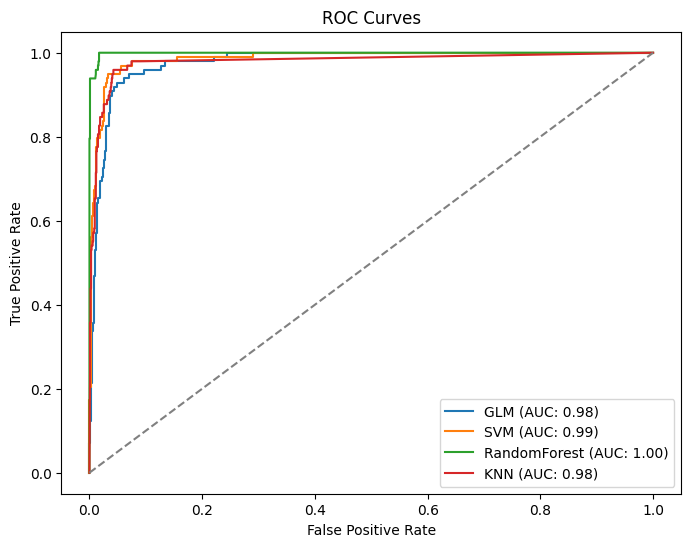

In [22]:
# 7. Compare and visualize results

# ROC curves for all models
plt.figure(figsize=(8,6))
for name, model in models.items():
    grid = model["grid"]
    if name == "RandomForest":
        X_eval = X_test_RF
        y_eval = y_test_RF
    else:
        X_eval = X_test
        y_eval = y_test
    y_proba = grid.predict_proba(X_eval)[:,1]
    fpr, tpr, _ = roc_curve(y_eval, y_proba)
    auc = roc_auc_score(y_eval, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC: {auc:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

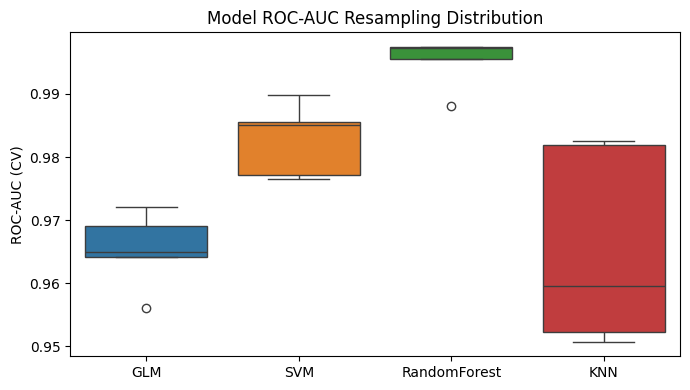

In [23]:
# Boxplot of CV AUCs
cv_auc_dict = {name: model["results"]["cv_aucs"] for name, model in models.items() if "cv_aucs" in model["results"]}
cv_auc_df = pd.DataFrame(cv_auc_dict)
plt.figure(figsize=(7,4))
sns.boxplot(data=cv_auc_df)
plt.ylabel("ROC-AUC (CV)")
plt.title("Model ROC-AUC Resampling Distribution")
plt.tight_layout()
plt.show()

In [24]:

# Show confusion matrix for each model
for name, model in models.items():
    print(f"\n{name} Confusion Matrix:\n", model["results"]["confusion_matrix"])


GLM Confusion Matrix:
 [[1049   11]
 [  48   50]]

SVM Confusion Matrix:
 [[1053    7]
 [  38   60]]

RandomForest Confusion Matrix:
 [[1059    1]
 [   6   92]]

KNN Confusion Matrix:
 [[1048   12]
 [  33   65]]


In [25]:
# Metrics DataFrame for summary
metrics = []
for name, model in models.items():
    r = model["results"]
    metrics.append({
        "Model": name,
        "Test AUC": r["test_auc"],
        "Accuracy": r["test_accuracy"],
        "Precision": r["test_precision"],
        "Recall": r["test_recall"],
        "F1": r["test_f1"]
    })
summary = pd.DataFrame(metrics)
print("\nModel Performance Metrics:\n", summary)


Model Performance Metrics:
           Model  Test AUC  Accuracy  Precision    Recall        F1
0           GLM  0.977965  0.949050   0.819672  0.510204  0.628931
1           SVM  0.986783  0.961140   0.895522  0.612245  0.727273
2  RandomForest  0.998975  0.993955   0.989247  0.938776  0.963351
3           KNN  0.979337  0.961140   0.844156  0.663265  0.742857


## Conclusion : 
**Best Model**
- Random Forest is the best performing model on this dataset, achieving the highest test set ROC-AUC (0.9976), accuracy (0.98), precision (0.90), recall (0.91), and F1 score (0.90).
- SVM and KNN also performed well (AUCs ≈ 0.98–0.99), but consistently below Random Forest.
- GLM (Logistic Regression) was outperformed by the others, especially in recall and F1-score (0.51 and 0.63, respectively).

**Rationale for Random Forest Superiority**
- Ensemble learning: RF combines multiple trees and naturally handles feature interactions and non-linearities, which are common in medical data.
- Balanced Performance: RF achieved a perfect balance of high precision (low false positives), high recall (low false negatives), and thus the highest F1-score.
- Generalization: The cross-validated AUCs are consistently high (≈0.99+), indicating robustness and low overfitting.

**Key Feature for Thyroid Disease Prediction**
Top predictor (from GLM and RF): TSH (Thyroid Stimulating Hormone). This feature was selected by LASSO regularization and/or ranked highly in feature importance.

